In [2]:
import autograd.numpy as np #tricky!
import autograd
from numpy import random as rdm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats

In [3]:
def move(A, P, n, max_loop=10, stdv=2, dim=3):

    iteration = 0
    acc = rdm.rand() #threshold required to accept sample
    W = 0 #Setting up metropolis acceptance prob
    while (W < acc and iteration <= max_loop):
        B = np.zeros(A.shape) #setting B to A raises issues
        B += A
        B[n] += stdv*stats.norm.rvs(size=(dim)) #random step

        W = P(np.array([B]))/P(np.array([A]))#Metropolis acceptance probability

    return B, W


def sample(P, M, N, window=2, equilib_time=1000, dim=3):
    """
    This function samples a probability distribution using Metropolis
    Markov Chain Monte Carlo. 
    
    Args:
        P: probability distribution
        M: number of samples
        N: number of particles
        window: dimension of box in which the initial point is generated
        
    """
    
    #generate initial sample
    samples = window*(rdm.rand(1, N, dim)-0.5)
    
    #Equilibration phase
    for m in range(equilib_time):
        for n in range(N):
            samples[0], W = move(samples[0], P, n, dim=dim)
            
    #Begin accumulating
    for m in range(1, M):
        #starts next sample at previous sample's location
        samples = np.append(samples, [samples[m-1]], axis=0)
        for n in range(N):
            #moves it 1 particle at a time
            samples[m], W = move(samples[m], P, n, dim=dim) 
            
    return samples

def expectation(f, P, M, N, window=2, equilib_time=1000, dim=3):
    """
    This function is the same as the previous but also evaluates an integral
    using the average formula described above. 
    
    Args:
        f: function of interest
        P: probability distribution
        M: number of samples
        N: number of particles
        window: dimension of box in which the initial point is generated
        
    """
    #generate initial sample
    samples = window*(rdm.rand(1, N, dim)-0.5)
    
    #Equilibration phase
    for m in range(equilib_time):
        for n in range(N):
            samples[0], W = move(samples[0], P, n)
            
    #Begin accumulating
    I = 0 #integral to be added to
    
    for m in range(1, int(M/N)):
        #note -- this time it's M/N to maintain M evaluations of f
        #starts next sample at previous sample's location
        samples = np.append(samples, [samples[m-1]], axis=0)
        for n in range(N):
            #saves previous move
            prev_move = samples[m]
            
            #moves it 1 particle at a time
            samples[m], W = move(samples[m], P, n)
            
            #Accumulates contribution to integral
            I += 1/(int(M/N)*N) * (W*f(samples[m]) + (1-W)*f(prev_move))
            
    return samples, I

In [57]:
#Defining some constants, as labeled above
a0 = 1
hbar = 1
e = 1
m = 1
k = 1

#Defining 2p orbital wave function
def p(X):
    """takes vector of form [[[x, y, z]], [[x,y,z]],...]"""
    #defining necessary spherical coordinates
    r = np.sqrt(np.sum(X**2, axis=-1))
    
    theta = np.arccos(X[:,:,0]/r)

    return (np.e**(-1/a0 * r/2))*r*np.cos(theta)

#Defining 2p modulus squared as the probability distribution P
def P(X):
    return p(X)**2 

def p_squeeze(X):
    return np.sum(p(X)) 

gradp = autograd.grad(p_squeeze)
print(gradp(np.array([[[1.0,1.0,1.0]]])))

def gradp_func(X, i):
    return gradp(X)[:,:,i]

grad2p = autograd.elementwise_grad(gradp_func)
print(grad2p(np.array([[[1.0,1.0,1.0]]]), i=0))

[[[ 0.29919748 -0.12142254 -0.12142254]]]
[[[-0.28874178 -0.04589669 -0.04589669]]]


In [80]:
def T(R, psi):
    
    grad1 = autograd.elementwise_grad(psi)

    def grad1_i(x, i):
        return grad1(x)[:,:,i]
    
    grad2 = autograd.elementwise_grad(grad1_i)


    #Because of some weird stuff with autograd's elementwise grad,
    #We have to look at each element separately. 
    x_comp = grad2(R, i=0)[:,:,0]
    y_comp = grad2(R, i=1)[:,:,1]
    z_comp = grad2(R, i=2)[:,:,2]

    laplace = x_comp + y_comp + z_comp

        
    return -laplace * (hbar**2)/(2*m)

def V_c(R):
    r = np.sqrt(np.sum(R**2, axis=-1))
    return -k*e**2/(r)

#Defining local energy.
def E_local(R, psi, V):
    E = np.sum(T(R, psi), axis=-1)

    E /= np.sum(psi(R), axis = -1)
    #print(np.sum(psi(R), axis=-1))

    E += np.sum(V(R), axis=-1)


    #print(np.isnan(E))

    where_nan = np.argwhere(np.isnan(E))
    #print(where_nan)
    for arg in where_nan:
        E[arg] = E[arg+1]
        #print(arg)
        #print(E[arg])

    return E

print(T(np.array([[[2.0,1.0,1.0]]]), p))

print(-(-0.1819-0.07547784-0.075477)/2)   
    
    

[[0.16645519]]
0.16642742000000002


In [ ]:
#A required local energy wrapper for 2p orbital
def p_E_local(R):
    return E_local(R, p, V_c)

p_samples = sample(p_E_local, P, 5000, 1)
p_energy = np.average(E_local(p_samples))

print(f'Calculated energy in Hartree units: {p_energy} Hartrees')
print(f'The actual energy of a p2 orbital in a Hydrogen atom is -0.12495 Hartrees')

In [22]:
samples = sample(P, 5000, 1)


In [70]:
#X = samples
#print(p(np.array([X[13]])))
#print(np.argwhere(np.isnan(p(samples))))

print(E_local(samples, p, V_c))
#print(samples)


[-0.28360751 -0.21174486 -0.15930269 ... -0.16218054 -0.27274542
 -0.21311108]


-0.125


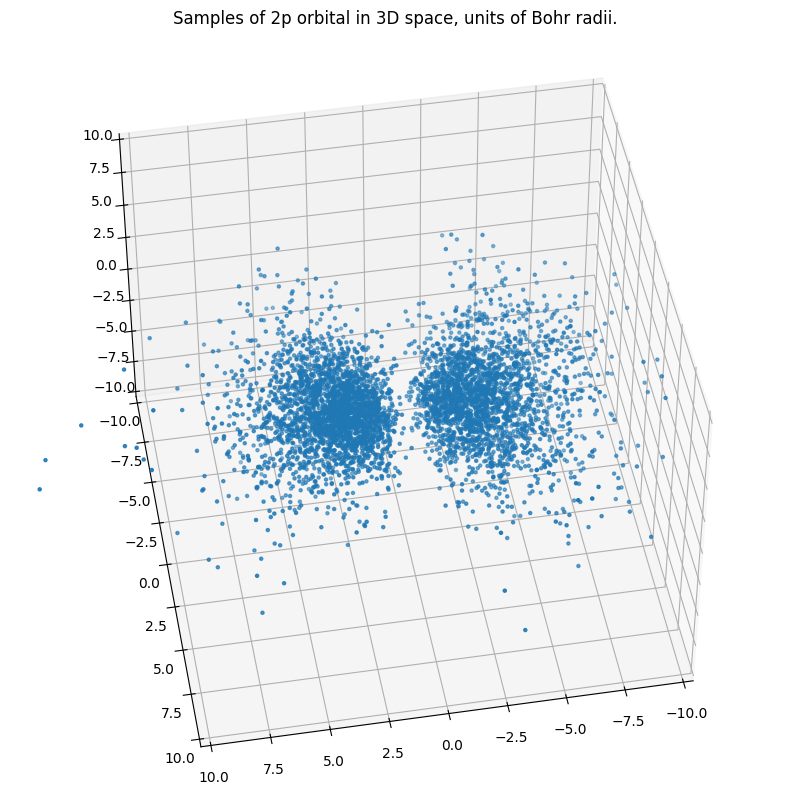

In [81]:
print(np.sum(E_local(samples, p, V_c))/5000)

#Create plot of sample distribution
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.view_init(45,80)

window = 10
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_title('Samples of 2p orbital in 3D space, units of Bohr radii.')

ax.scatter(samples[:, 0, 0], samples[:, 0, 1], samples[:, 0, 2], marker = ".")


In [18]:
def f(x):
    return np.sum(x**3, axis=-1)

jac = autograd.vector_jacobian_product(f)
#grad2_f = autograd.jacobian(grad_f)
def grad_f(r, i):
    return jac(r, np.ones(r.shape[0]))[0,:,:,i]


#print(grad_f(samples))

jac2 = autograd.vector_jacobian_product(grad_f)
#grad2_f = autograd.jacobian(grad_f)
#laplace = np.sum(jac2(samples, np.ones(samples.shape[0])), axis=-1)

#jac2 = grad2_f(samples)

laplace = jac2(samples[0:3], np.ones(3), i=0)[0,:,:,0]
laplace += jac2(samples[0:3], np.ones(3), i=1)[0,:,:,1]
laplace += jac2(samples[0:3], np.ones(3), i=2)[0,:,:,2]
print(laplace)



[[16.23378766]
 [24.75033113]
 [38.1969887 ]]


In [39]:
grad1 = autograd.elementwise_grad(f)
print(grad1(np.array([1.0,1.0,1.0])))

grad2 = autograd.elementwise_grad(grad1)
print(grad2(np.array([1.0,1.0,1.0])))

print(-np.sum(grad2(np.array([1.0,1.0,1.0])))/2)

[3. 3. 3.]
[6. 6. 6.]
-9.0


In [48]:
def T2(R, psi):
    def psi_squeeze(R):
        return np.sum(psi(R))
    grad_psi = autograd.grad(psi_squeeze)
    
    #What follows is made difficult since autograd has no Laplacian
    def grad1(R, n, i):
        return grad_psi(R)[0, n, i]
    
    print(grad1(R, 0, 0))
    
    laplace = 0
    if (R.size > 1):
        for n in range(1):
            for i in range(3):
                grad2 = autograd.grad(grad1)
                print(grad2(R, n, i)[n,i])
                laplace += np.sum(grad2(R, n, i)[n, i])
    else:
        doublegrad_psi = autograd.grad(grad_psi)
        laplace += np.sum(doublegrad_psi(R))
    
    return -np.sum(laplace * hbar**2 / (2*m))

print(T2(np.array([[[1.0,1.0,1.0]]), p))

0.29919748341966945
[-0.28874178 -0.04589669 -0.04589669]


IndexError: index 1 is out of bounds for axis 1 with size 1